# Notebook to Explore and model the relationship between current weather and current power generation from one wind turbine 

## Import usefull packages and dataset

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smf
import seaborn as sns
import os
import statsmodels
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('Wind_Dataset.csv')
data.head()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645904          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286

# Format datetime, clean up column names, build seasonality features

In [20]:
data.rename(columns = {'LV ActivePower (kW)':'ActivePower(kW)',
                       "Wind Speed (m/s)":"WindSpeed(m/s)",
                       "Wind Direction (°)":"WindDirection","Theoretical_Power_Curve (KWh)":"TheoreticalPowerCurve(KWh)"},
            inplace = True)


data['Date/Time'] = pd.to_datetime(data['Date/Time'],format='%d %m %Y %H:%M')
data['year'] = data['Date/Time'].dt.year 
data['month'] = data['Date/Time'].dt.month 
data['day'] = data['Date/Time'].dt.day

data['Hour'] = data['Date/Time'].dt.hour 
data['minute'] = data['Date/Time'].dt.minute 
data['doy'] = data['Date/Time'].dt.dayofyear

data['sin_doy'] = np.sin(np.deg2rad(data['Date/Time'].dt.dayofyear))

data.head()

Date/Time  ActivePower(kW)  WindSpeed(m/s)  \
0 2018-01-01 00:00:00       380.047791        5.311336   
1 2018-01-01 00:10:00       453.769196        5.672167   
2 2018-01-01 00:20:00       306.376587        5.216037   
3 2018-01-01 00:30:00       419.645904        5.659674   
4 2018-01-01 00:40:00       380.650696        5.577941   

   TheoreticalPowerCurve(KWh)  WindDirection  year  month  day  Hour  minute  \
0                  416.328908     259.994904  2018      1    1     0       0   
1                  519.917511     268.641113  2018      1    1     0      10   
2                  390.900016     272.564789  2018      1    1     0      20   
3                  516.127569     271.258087  2018      1    1     0      30   
4                  491.702972     265.674286  2018      1    1     0      40   

   binnedSpeed  binnedDirection   sin_doy  doy  
0          5.5              270  0.017452    1  
1          5.5              270  0.017452    1  
2          5.0              270  0.017452    1  
3          5.5              270  0.017452    1  
4          5.5              270  0.017452    1

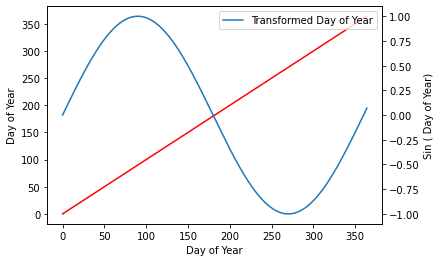

In [31]:
# this is an excellent way of explicitly incorperating seasonality into EDA and model fitting as it transforms 
# the linear term DOY into a periodic feature in which the first and the last day of the year are similiar in scale

fig,ax = plt.subplots()
ax2 = plt.twinx()
ax.plot(list(range(365)),list(range(365)),color = 'red',label = 'Day of the Year')
ax.set_ylabel('Day of Year')
ax2.plot(list(range(365)),np.sin(np.deg2rad(list(range(365)))),label = 'Transformed Day of Year')
ax2.set_ylabel("Sin ( Day of Year)")
ax.set_xlabel('Day of Year')
plt.legend()

# Some more feature engineering .... bin wind speed and direction to assist in some exploration

In [14]:
def binned_speed(x):
    """
    Function to bin wind speed values into categories seperated by 0.5 m/s
    """
    x = round(x,2)
    a = x//1
    a,b = a+0.25,a+0.75
    if x < a:
        x = a - 0.25
    else:
        x = b -0.25
    return x

In [12]:
data['binnedSpeed'] = data['WindSpeed(m/s)'].apply(binned_speed)
data.head()

Date/Time  ActivePower(kW)  WindSpeed(m/s)  \
0 2018-01-01 00:00:00       380.047791        5.311336   
1 2018-01-01 00:10:00       453.769196        5.672167   
2 2018-01-01 00:20:00       306.376587        5.216037   
3 2018-01-01 00:30:00       419.645904        5.659674   
4 2018-01-01 00:40:00       380.650696        5.577941   

   TheoreticalPowerCurve(KWh)  WindDirection  year  month  day  Hour  minute  \
0                  416.328908     259.994904  2018      1    1     0       0   
1                  519.917511     268.641113  2018      1    1     0      10   
2                  390.900016     272.564789  2018      1    1     0      20   
3                  516.127569     271.258087  2018      1    1     0      30   
4                  491.702972     265.674286  2018      1    1     0      40   

   binnedSpeed  binnedDirection  
0          5.5              270  
1          5.5              270  
2          5.0              270  
3          5.5              270  
4          5.5              270

In [8]:
def binned_direction(x):
    """
    Function to round wind direction in degrees to a standard cardinal heading
    """
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x

In [13]:
data["binnedDirection"]=data["WindDirection"].apply(binned_direction)
data.head()

Date/Time  ActivePower(kW)  WindSpeed(m/s)  \
0 2018-01-01 00:00:00       380.047791        5.311336   
1 2018-01-01 00:10:00       453.769196        5.672167   
2 2018-01-01 00:20:00       306.376587        5.216037   
3 2018-01-01 00:30:00       419.645904        5.659674   
4 2018-01-01 00:40:00       380.650696        5.577941   

   TheoreticalPowerCurve(KWh)  WindDirection  year  month  day  Hour  minute  \
0                  416.328908     259.994904  2018      1    1     0       0   
1                  519.917511     268.641113  2018      1    1     0      10   
2                  390.900016     272.564789  2018      1    1     0      20   
3                  516.127569     271.258087  2018      1    1     0      30   
4                  491.702972     265.674286  2018      1    1     0      40   

   binnedSpeed  binnedDirection  
0          5.5              270  
1          5.5              270  
2          5.0              270  
3          5.5              270  
4          5.5              270

# Bin observations by cardinal direction

In [33]:
directiondict = {0:"N", 30:"NNE", 60:"NEE", 90:"E", 120:"SEE", 150:"SSE", 180:"S", 210:"SSW", 240:"SWW", 270:"W", 300:"NWW", 330:"NNW"}
def wind_direction(x):
    return directiondict[x]

In [34]:
data['windCDirection'] = data['meanDirection'].apply(wind_direction)

In [35]:
list_data=[]
list_yon=["N","NNE","NEE","E","SEE","SSE","S","SSW","SWW","W","NWW","NNW"]

for i in range(0,12):
    data1T_A=data[data["windCDirection"] == list_yon[i]]
    
    DepGroup_A = data1T_A.groupby("meanSpeed")
    data_T_A = DepGroup_A.mean()
    
    data_T_A.drop(columns = {"WindSpeed(m/s)",
                             "WindDirection",
                             "meanDirection"},
                  inplace = True)
    
    listTA_WS = data_T_A.index.copy()
    data_T_A["WindSpeed(m/s)"] = listTA_WS
    
    data_T_A = data_T_A[["WindSpeed(m/s)",
                         "ActivePower(kW)",
                         "TheoreticalPowerCurve(KWh)"]]
    
    data_T_A["Index"] = list(range(1,len(data_T_A.index)+1))

    data_T_A.set_index("Index", inplace = True)
    
    data_T_A = data_T_A.round({'ActivePower(kW)': 2,
                             'TheoreticalPowerCurve(KWh)': 2})
    
    data_T_A["count"] = [len(data1T_A["meanSpeed"][data1T_A["meanSpeed"] == x]) for x in data_T_A["WindSpeed(m/s)"]]
    list_data.append(data_T_A)


In [36]:
data_T_N = list_data[0]
data_T_NNE = list_data[1]
data_T_NEE = list_data[2]
data_T_E = list_data[3]
data_T_SEE = list_data[4]
data_T_SSE = list_data[5]
data_T_S = list_data[6]
data_T_SSW = list_data[7]
data_T_SWW = list_data[8]
data_T_W = list_data[9]
data_T_NWW = list_data[10]
data_T_NNW = list_data[11]

list_table=[data_T_N,data_T_NNE,data_T_NEE,data_T_E,data_T_SEE,data_T_SSE,data_T_S,
            data_T_SSW,data_T_SWW,data_T_W,data_T_NWW,data_T_NNW]

list_tableName=["N","NNE","NEE","E","SEE","SSE","S","SSW","SWW","W","NWW","NNW"]

# Plot theoretical and actual power curve across cardinal directions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

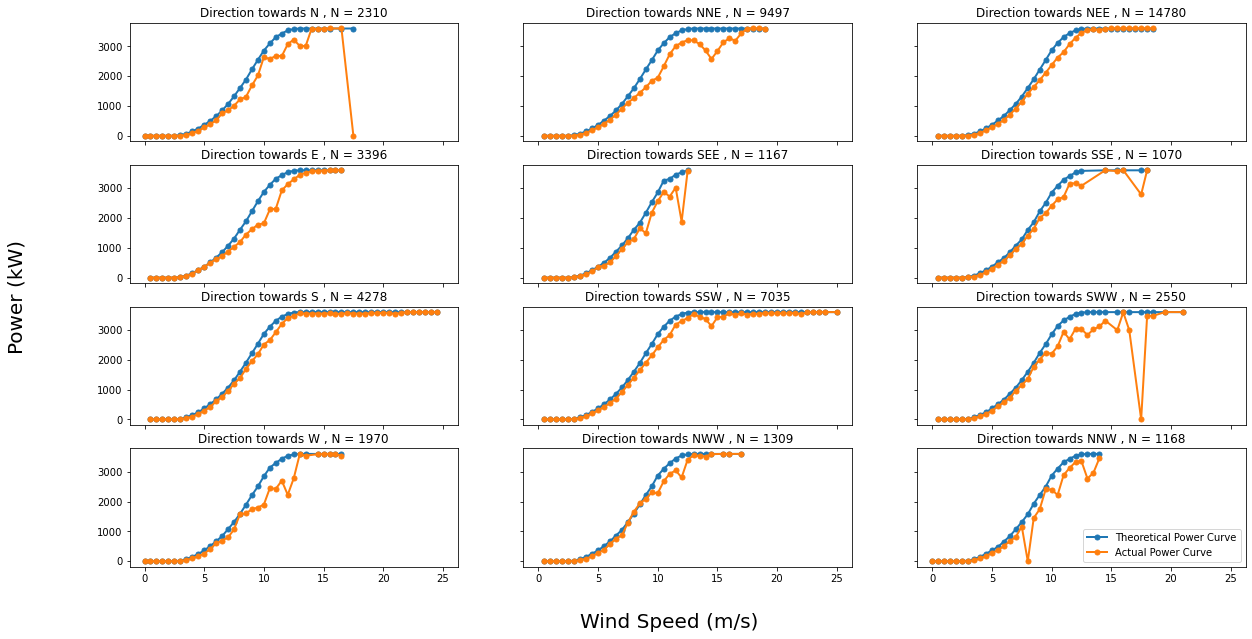

In [37]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(20,10));
axes=axes.flatten();

def graph_T(i):
    axes[i].plot(list_table[i]["WindSpeed(m/s)"],
             list_table[i]["TheoreticalPowerCurve(KWh)"],
             label = "Theoretical Power Curve",
             marker = "o", markersize = 5, linewidth = 2);
    
    axes[i].plot(list_table[i]["WindSpeed(m/s)"],
             list_table[i]["ActivePower(kW)"],
             label = "Actual Power Curve",
             marker = "o", markersize = 5, linewidth = 2);
    

    axes[i].set_title("Direction towards {} , N = {}".format(list_tableName[i],list_table[i]['count'].sum()));
    plt.legend();
    #plt.show()
    #fig.savefig("{}_Powercurve.jpeg".format(list_tableName[i]))
    #plt.close(fig)
    
for i in range(0,12):
    graph_T(i);

fig.text(0.5, 0.04, 'Wind Speed (m/s)', ha='center',size = 20);
fig.text(0.04, 0.5, 'Power (kW)', va='center', rotation='vertical',size = 20);


# Model Training

## First we will use a simple GLM Model to produce a baseline fit with easily interpretable effectsdata

In [ ]:
import statsmodels.api as sm

In [46]:
X = data[[ 'WindDirection', 'sin_doy', 'Hour', 'WindSpeed(m/s)']]
y = data['ActivePower(kW)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [50]:
mod = sm.OLS(y_train,sm.add_constant(X_train))
mod = mod.fit()

In [52]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ActivePower(kW)   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 4.511e+04
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:00:13   Log-Likelihood:            -2.7216e+05
No. Observations:               35371   AIC:                         5.443e+05
Df Residuals:                   35366   BIC:                         5.444e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -897.6002      8.514   -105.427      0.000    -914.288    -880.913
WindDirection      0.2900      0.031      9.300      0.000       0.229       0.351
sin_doy          -91.5008      4.148    -22.061      0.000     -99.630     -83.371
Hour               3.0055      0.407      7.380      0.000       2.207       3.804
WindSpeed(m/s)   282.6787      0.670    421.944      0.000     281.366     283.992
==============================================================================
Omnibus:                    11200.634   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58251.608
Skew:                          -1.440   Prob(JB):                         0.00
Kurtosis:                       8.589   Cond. No.                         470.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Interpretation 

OK Great, it looks like all of our potential main effects are statistically significant, more over, we see that both wind direction and wind speed have a positive coefficient, indicating a linear positive effect on estimating active wind power. 

In [62]:
# assess fit on training data set

y_hat_test = mod.predict(sm.add_constant(X_test))
y_hat_train = mod.predict(sm.add_constant(X_train))

In [64]:
print('train r2 =',r2_score(y_train,y_hat_train))
print('validation r2 =',r2_score(y_test,y_hat_test))


print('train mse =',mean_squared_error(y_train,y_hat_train))
print('validation mse =',mean_squared_error(y_test,y_hat_test))

train r2 = 0.8361278514340278
validation r2 = 0.8346346466596084
train mse = 282383.27248317335
validation mse = 284582.26808717666


 we observe that the validation scores are slightly better than the training scores, but not by a significant margin, which is one indication that our simple model is not overfit to this data

# MVP Model : Random Forest

In [67]:
data['train']=0
data['train_color']='test'

In [68]:
data.loc[X_train.index,'train']=int(1)
data.loc[X_train.index,'train_color']='train'

In [71]:
# Train a random forest regressor 
regr = RandomForestRegressor(max_depth=6, random_state=0)
regr.fit(X_train, y_train)
pred_train_rf= regr.predict(X_train)

print("Training MSE and R2 score:")
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf= regr.predict(X_test)
print("Testing MSE and R2 score:")
print(np.sqrt(mean_squared_error(y_test,pred_test_rf))) 
print(r2_score(y_test, pred_test_rf))

data['y_hat_rf'] = regr.predict(X)

Training RMSE and R2 score:
325.5331089979797
0.9385026342782745
Testing RMSE and R2 score:
339.27356151089765
0.9331137692995959


### off the bat, we observe that the random forest is able to achieve a much higher fit, boosting performance by about 10% from the baseline OLS regression/

# Model Performance Analysis

In addition to looking at point level indicators of fit and performance like r2 and MSE, its super helpful to assess residuals and fit accross the distribution of the models input space

In [73]:
import plotly.express as px

In [74]:
data['train'] = data['train'].astype(int)

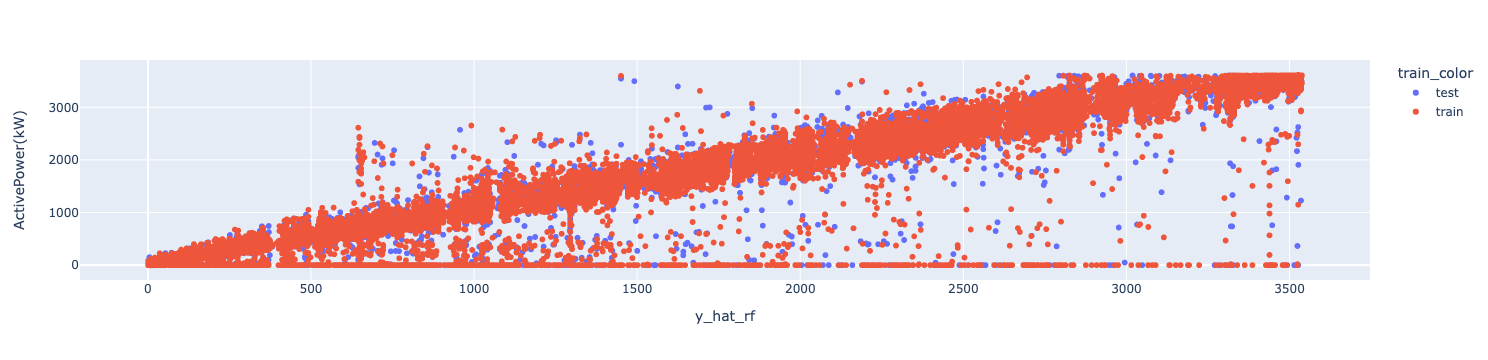

In [75]:
px.scatter(data, x='y_hat_rf', y='ActivePower(kW)', color='train_color')

In this plot, we point out that the model produces large over estimations at low active power thresholds, this is likely during periods of low wind. Lets take a look at the residuals accross the wind values

Text(0.5, 1.0, 'Wind Speed vs. Actual & Predicted Power')

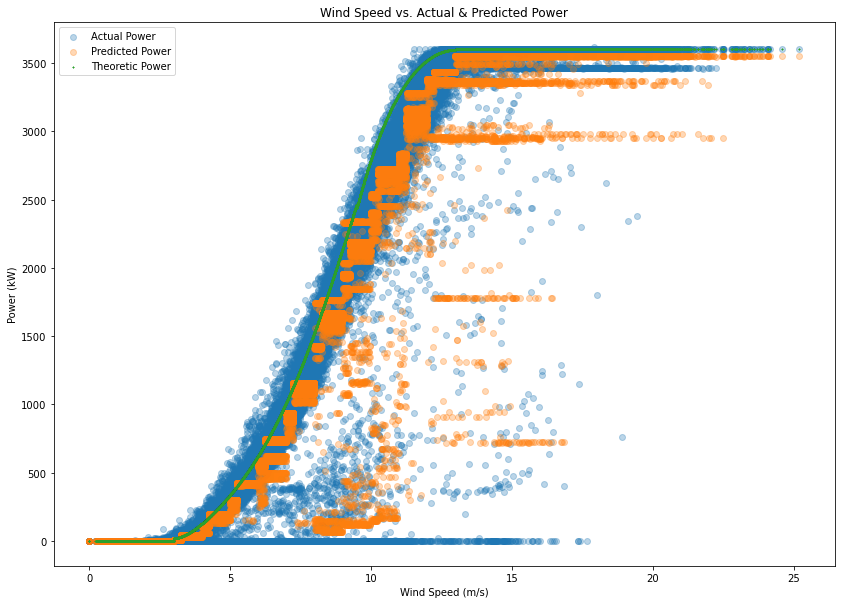

In [120]:
fig,ax = plt.subplots(figsize = [14,10])
plt.scatter(data['WindSpeed(m/s)'],data['ActivePower(kW)'],label = 'Actual Power',alpha = 0.3)
plt.scatter(data['WindSpeed(m/s)'],data['y_hat_rf'],label = 'Predicted Power',alpha = 0.3)

plt.scatter(data['WindSpeed(m/s)'],data['TheoreticalPowerCurve(KWh)'],label = 'Theoretic Power',marker='x',s=1)
plt.legend()
plt.xlabel("Wind Speed (m/s)")
plt.ylabel('Power (kW)')
plt.title("Wind Speed vs. Actual & Predicted Power")

### This figure shows us a couple different strengths/weaknessess of the model

* First we see that there are roughly 4 clusters of estimations that underpredict wind power in the 10-18 m/s wind speed range
* Second we see that on average, the models estimations are within the distribution of actual power at different wind speeds. However, there are a slew of observations that the model was not able to predict at low to mid wind speeds in which corresponding turbines produced low to no power. In this case, I'd want to know more about factors external to our present dataset. There may be factors such as planned shut downs or equiptment malfunction that we are not currently accounting for.

# Aggregate to Daily resolution

In [92]:
data_daily = data.groupby(data['Date/Time'].dt.date).sum()

In [94]:
print(np.sqrt(mean_squared_error(data_daily['ActivePower(kW)'],data_daily['y_hat_rf']))) 
print(r2_score(data_daily['ActivePower(kW)'],data_daily['y_hat_rf']))

26588.253679365836
0.9696749318728494


In [95]:
data_daily['mean_windSpeed'] = data.groupby(data['Date/Time'].dt.date)['WindSpeed(m/s)'].mean()
data_daily['residual_rf'] = data_daily['y_hat_rf'] - data_daily['ActivePower(kW)']

Text(0.5, 1.0, ' Daily Aggregation Wind Speed vs. Actual & Predicted Power')

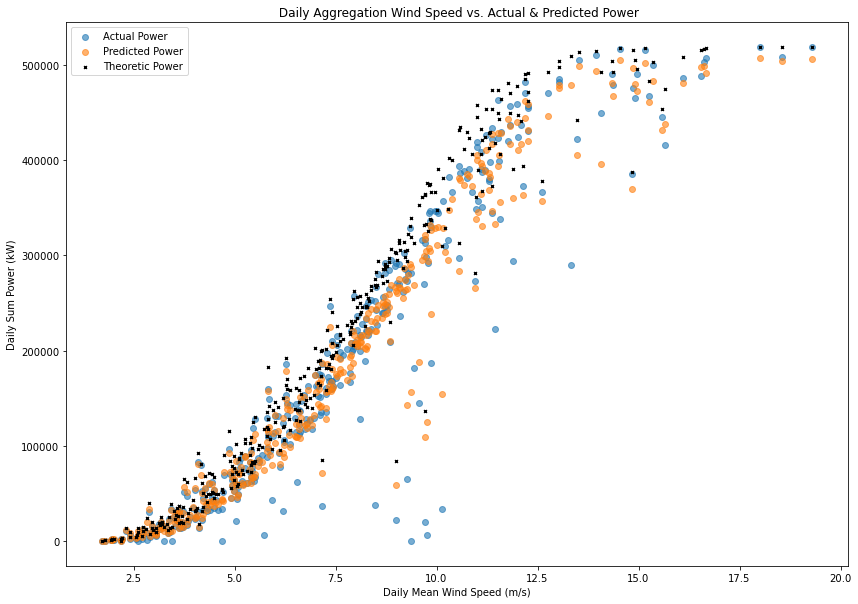

In [96]:
fig,ax = plt.subplots(figsize = [14,10])
plt.scatter(data_daily['mean_windSpeed'],data_daily['ActivePower(kW)'],label = 'Actual Power',alpha = 0.6)
plt.scatter(data_daily['mean_windSpeed'],data_daily['y_hat_rf'],label = 'Predicted Power',alpha = 0.6)

plt.scatter(data_daily['mean_windSpeed'],data_daily['TheoreticalPowerCurve(KWh)'],label = 'Theoretic Power',marker='x',s=8, color = 'black')
plt.legend()
plt.xlabel("Daily Mean Wind Speed (m/s)")
plt.ylabel('Daily Sum Power (kW)')
plt.title(" Daily Aggregation Wind Speed vs. Actual & Predicted Power")

In [110]:
data_daily['percent_error'] = (data_daily['residual_rf']/(data_daily['ActivePower(kW)']+.1))*100

In [112]:
# a selection of problem days!
data_daily[data_daily['percent_error']>100].shape

(18, 19)

### Looks like there are 19 outlier days that is obscuring our global view of model performance at the daily scale, we will remove this for now and cirlce back in the future to examine what potential causes may bedata_daily

In [113]:
data_daily_filt = data_daily[data_daily['percent_error']<100]

In [104]:
data_daily_filt['zero'] = 0

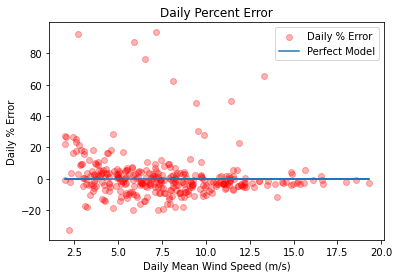

In [114]:
plt.scatter(data_daily_filt['mean_windSpeed'],data_daily_filt['percent_error'],c = 'red',label = 'Daily % Error',alpha = 0.3)
plt.plot(data_daily_filt['mean_windSpeed'],data_daily_filt['zero'],label = 'Perfect Model')
plt.xlabel("Daily Mean Wind Speed (m/s)")
plt.ylabel('Daily % Error')
plt.title('Daily Percent Error')
plt.legend()

This plot is super helpful, this indicates that the model tends to produce positive error (over prediction) at low wind speeds and negative error at mid wind speeds that starts to reduce and trend towards low error as wind speeds rise.

In [115]:
# Lets take a look at feature importance!

In [116]:
feature_names = regr.feature_names_in_

In [117]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. WindSpeed(m/s) (0.975745)
2. sin_doy (0.017661)
3. WindDirection (0.006351)
4. Hour (0.000242)


In [119]:
# I'm not suprised that wind speed and seasonality take the cake here. 

# Error in Time

Since the data set is limited to only one year, I choose to split the data randomly, pulling observations from all seasons. While this is a necesarry exposure for the model to have, it also obscures our ability to assess model performance in continous time. This figure is the active and estimated power accross the entire data set aggregated to teh day.

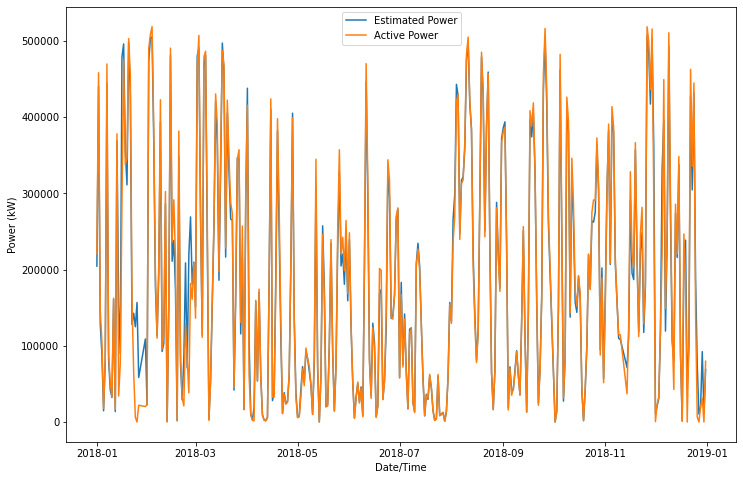

In [121]:
fig,ax = plt.subplots(figsize = [12,8])
data_daily['y_hat_rf'].plot(label = 'Estimated Power')
data_daily['ActivePower(kW)'].plot(label = 'Active Power')
plt.ylabel('Power (kW)')
plt.legend()

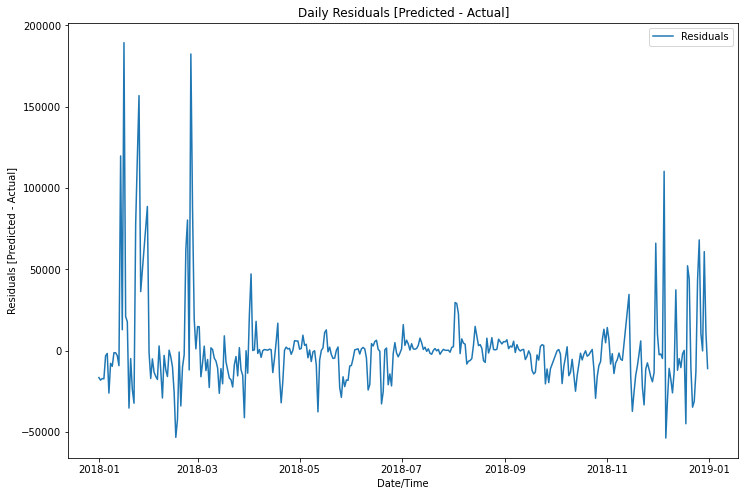

In [125]:
fig,ax = plt.subplots(figsize = [12,8])
data_daily['residual_rf'].plot(label = 'Residuals')
plt.ylabel('Residuals [Predicted - Actual]')
plt.title('Daily Residuals [Predicted - Actual]')
plt.legend()

By looking at the residuals in time, we see that the error seems to be concentrated in the winter months, specifically Decemeber - Febuary. In many of these winter error days, the model is tending to over predict the amount of energy that is generated. As I mentioned about, there are many reasons why this may be the case. Two really come to top of my mind though, in the case of a severe weather event, the turbine may be shut down, in which case there would be very high winds and no power generated. To test this theory, I'd love to cross reference the date and location of the event and turbine with a full weather data set and a severe weather report. 